# **Supervised Learning (Decision Tree, RF, XGBoost)**

In [1]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Rainfall Prediction Dataset
We will be using a dataset about rainfall prediction for **Decision Tree**, **Random Forest** & **XGBoost**.

# Recap on Dataset:

*   Contains daily weather observations for various location, including both numerical and categorical measurements.
*   **Goal**: Predict whether it will rain the next day (RainTomorrow).

In [2]:
# Load data

path = kagglehub.dataset_download("sandhyapalaniappan/rainfall-prediction-dataset-cleaned-weatheraus")
data = pd.read_csv(path + "/weatherAUS_rainfall_prediction_dataset_cleaned.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2010-04-30,Adelaide,10.8,21.2,0.0,1.8,6.60,ENE,22.0,ENE,...,66.0,48.0,1028.4,1024.7,4.45,4.51,15.7,21.0,No,No
1,2014-07-22,Adelaide,3.7,19.0,0.0,1.4,7.61,N,24.0,N,...,75.0,32.0,1024.2,1021.1,4.45,4.51,9.6,18.5,No,No
2,2014-07-23,Adelaide,9.6,15.8,0.0,2.6,7.61,NE,52.0,NNE,...,35.0,51.0,1017.9,1011.5,4.45,4.51,14.7,15.4,No,Yes
3,2014-07-24,Adelaide,10.1,15.5,16.6,0.8,7.61,NNE,50.0,NW,...,96.0,80.0,1007.4,1008.0,4.45,4.51,11.2,14.0,Yes,Yes
4,2014-07-25,Adelaide,11.2,16.2,1.8,0.6,7.61,NW,30.0,WNW,...,89.0,70.0,1018.4,1019.2,4.45,4.51,13.0,15.3,Yes,Yes


# **Decision Tree for Classification**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define features & target
# Features (independent variables)
X = data[['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm']]

# Target (dependent / response variable)
y = data['RainTomorrow']

# Split into test & training set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)





Training set shape: (116368, 7)
Test set shape: (29092, 7)


In [4]:
# class imbalance
print("Class distribution in y_train:")
print(y_train.value_counts())

Class distribution in y_train:
RainTomorrow
No     90791
Yes    25577
Name: count, dtype: int64


Here we encounter the problem of **class imbalance**.

Class imbalance means one class (e.g. "No Rain") is much more frequent than the other ("Rain").
* If not addressed, models may simply predict the majority class, ignoring the minority.
* Handling imbalance (e.g. with class weights or scale_pos_weight) helps the model pay more attention to the minority class, improving its ability to detect rare events like rain.

Thus, we tackle it using class_weight = 'balanced' for DT & RF, and scaling for XGBoost later on.




Train the Decision Tree (using the 80% of data set aside for training)

In [5]:
# Create Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, 
                                  max_depth=5, 
                                  class_weight = 'balanced')

# Train the model
dt_model.fit(X_train, y_train)

# Predict on test set
y_pred = dt_model.predict(X_test)

# Compute precision (with "Yes" as positive class)
precision = precision_score(y_test, y_pred, pos_label="Yes")
print(f"Precision: {precision:.2f}")


Precision: 0.47


Visualise the Tree!

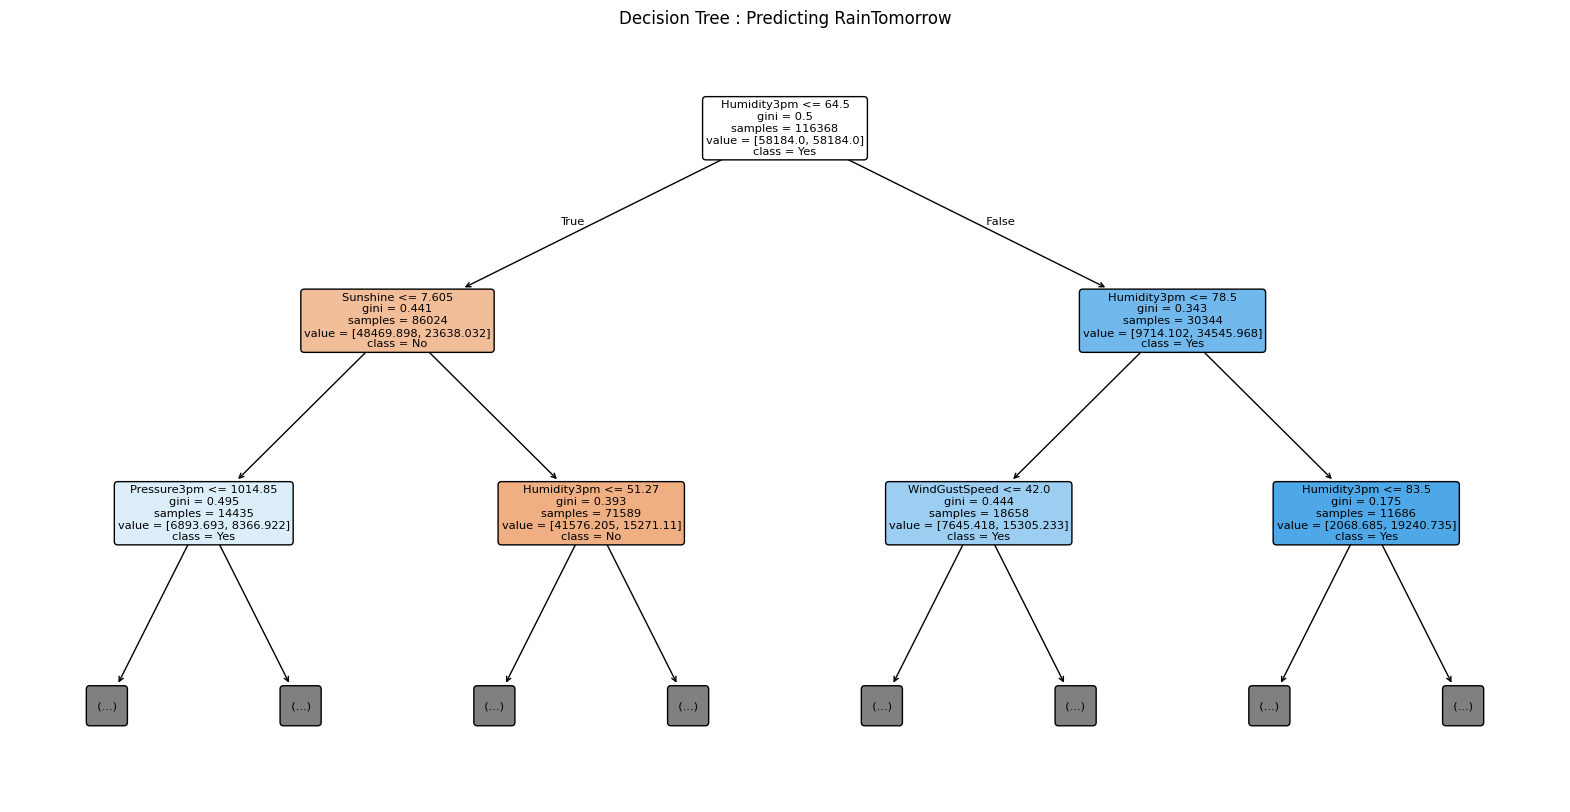

In [6]:
plt.figure(figsize=(20,10))

#Here, we set max depth = 2 to get a better understanding of the split, but feel free to remove to see the entire tree in your own time
plot_tree(dt_model,
          filled=True,
          feature_names=X.columns,
          class_names=["No", "Yes"],
          max_depth=2,
          rounded=True)
plt.title("Decision Tree : Predicting RainTomorrow")
plt.show()


Now that we understand how Decision Trees work, let's try to predict a few points to see how it performs

In [7]:
#Here, I use the same test_days as with Daeren's model
test_days = pd.DataFrame({
    'MinTemp': [15, 8, 22, 12, 18],
    'MaxTemp': [25, 18, 30, 20, 28],
    'Rainfall': [0.0, 5.0, 0.0, 10.0, 2.5],
    'Sunshine': [8.0, 3.5, 10.0, 2.0, 6.5],
    'WindGustSpeed': [25, 40, 15, 30, 20],
    'Humidity3pm': [45, 80, 35, 90, 60],
    'Pressure3pm': [1020, 1005, 1015, 1008, 1018]
})

pred_class = dt_model.predict(test_days)
pred_prob = dt_model.predict_proba(test_days)

for i, (cls, prob) in enumerate(zip(pred_class, pred_prob)):
    print(f"Day {i+1}: Predicted RainTomorrow = {cls}, Probability of rain = {prob[1]:.2f}")


Day 1: Predicted RainTomorrow = No, Probability of rain = 0.08
Day 2: Predicted RainTomorrow = Yes, Probability of rain = 0.80
Day 3: Predicted RainTomorrow = No, Probability of rain = 0.20
Day 4: Predicted RainTomorrow = Yes, Probability of rain = 0.94
Day 5: Predicted RainTomorrow = No, Probability of rain = 0.38


Now that we have an idea on how Decision Trees, let's go back to our original dataset and look at the given metric: Accuracy, and visualise it in a plot.

In [8]:
# Test tree depths from 1 to 20
depth_values = list(range(1, 21))
train_acc = []
test_acc = []

for d in depth_values:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Accuracy scores
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))


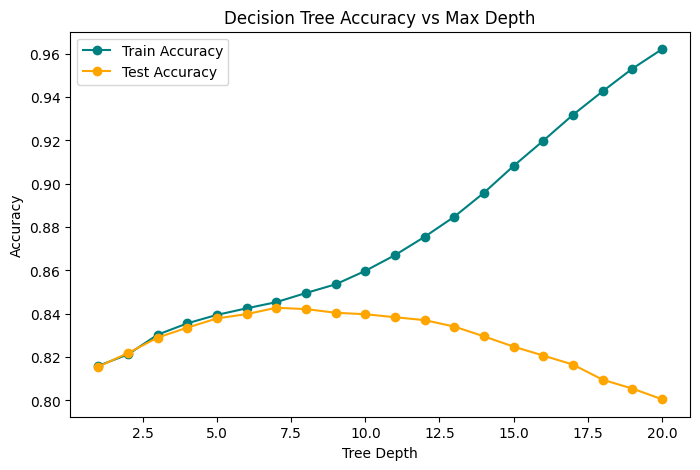

In [9]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(depth_values, train_acc, marker='o', label='Train Accuracy', color='teal')
plt.plot(depth_values, test_acc, marker='o', label='Test Accuracy', color='orange')
plt.title("Decision Tree Accuracy vs Max Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As explained on the slides, we see how a decision tree might achieve high accuracy on training data (because it keeps splitting until nearly pure leaves), but this can lead to overfitting, and the test data performs horribly as the max depth continues to increase beyond a certain point.

# **Random Forest**

Now, we'll build upon what we've learnt from a simple decision tree to form the random forest model.

Random Forest builds many decision trees in parallel, each trained on random subsets of the data and features. By **averaging their predictions**, the model reduces variance and becomes more robust to overfitting.

The key parameters here:
*   max_depth: controls the depth of each tree, determining how complex individual trees can be
*   n_estimators:  number of trees in the entire forest (more trees = better averaging, but slower)







In [10]:
from sklearn.ensemble import RandomForestClassifier

# Use the same X_train, X_test, y_train, y_test as before for baseline rf
rf = RandomForestClassifier(
    n_estimators=200, #number of trees in the forest (more trees = better averaging, but slower
    max_depth = 5, #depth of each tree
    random_state=42, #seed for reproducibility
    class_weight='balanced'  # # automatically balances weights for imbalanced classes, which helps if "Yes" is less frequent
)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]  # P(RainTomorrow = Yes)

print("Accuracy :", round(accuracy_score(y_test, y_pred),3))
print("Precision:", round(precision_score(y_test, y_pred, pos_label="Yes"),3))
print("Recall   :", round(recall_score(y_test, y_pred, pos_label="Yes"),3))

#Here, we fixed a certain level for our n_estimators, and our metrics reflect the scores specifically when n_estimators = 200

Accuracy : 0.776
Precision: 0.489
Recall   : 0.749


Here, we **visualise what the Random Forest has "learned"**.

Note that instead of one big tree diagram, Random Forest summarises which features mattered most across all trees.
High bars (e.g. Humidity3pm) are the features the model frequently split on to decide rain vs no rain.

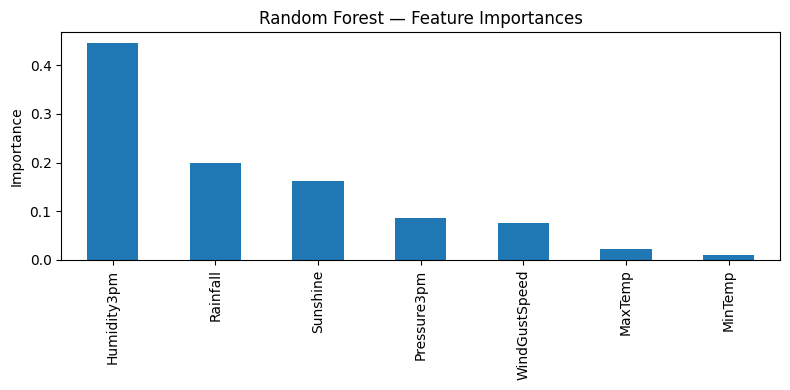

In [11]:
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,4))
fi.plot(kind='bar')
plt.title("Random Forest — Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Mirroring our approach with how we adjust depth to refine accuracy, let's **adjust depth to observe how precision & recall** work!

Additionally, we observe what happens when we let each decision tree grow fully (max_depth = None).

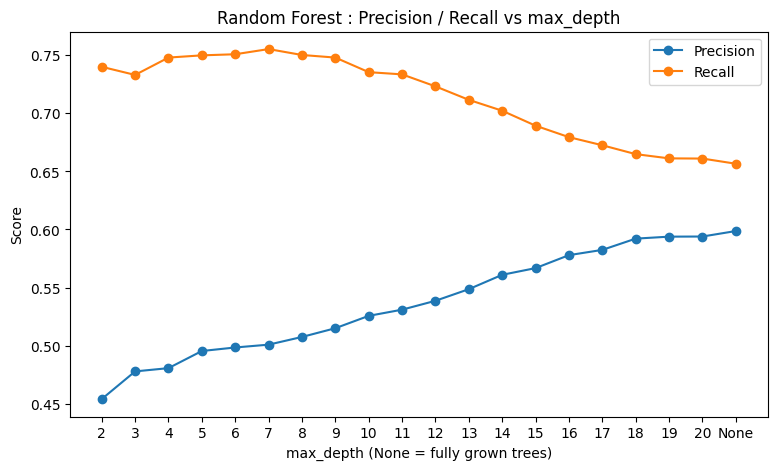

In [12]:
depth_values = list(range(2, 21)) + [None]
precisions, recalls = [], []

for d in depth_values:
    model = RandomForestClassifier(
        n_estimators=50,
        max_depth=d,          # per-tree depth limit
        max_samples=0.5,        # use 50% of rows per tree (RF is very big so it runs slowly otherwise)
        min_samples_leaf=5,     # bigger leaves so it is faster
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    precisions.append(precision_score(y_test, y_hat, pos_label='Yes'))
    recalls.append(recall_score(y_test, y_hat, pos_label='Yes'))

labels = [str(d) for d in depth_values[:-1]] + ["None"]

plt.figure(figsize=(9,5))
plt.plot(labels, precisions, marker='o', label='Precision')
plt.plot(labels, recalls,   marker='o', label='Recall')
plt.title("Random Forest : Precision / Recall vs max_depth")
plt.xlabel("max_depth (None = fully grown trees)")
plt.ylabel("Score")
plt.legend()
plt.show()


**Precision** : "Of the days I said it would rain, how many actually did?"
*   Shallow trees are more cautious, predicting rain only when it is sure
*   As trees grow deeper, they become more confident, which results in fewer false alarms and higher precision.

**Recall** : "Of all the days it actually rained, how many did I catch?"
* Deeper trees usually increase recall, since they fit more specific conditions and detect more rainy days.
*  However, if trees grow too deep, the model becomes overconfident on training data and less generalizable on new data. On the test set, it starts missing some rainy days, which explains the drop in recall beyond around depth ≈ 7.


As tree depth increases, Random Forest experiences an increase in precision, and a fall in recall, implying that it becomes better at being right when it predicts rain, but misses more actual rainy days.
The goal is to find a depth that balances both, capturing most rainy days without overpredicting.



In [13]:
best_depth = 8  # for example, based on where F1 or precision/recall balance looks "best", but this is also arbitrary!
rf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=best_depth,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_final.fit(X_train, y_train)
y_pred_final = rf_final.predict(X_test)
print(classification_report(y_test, y_pred_final))


              precision    recall  f1-score   support

          No       0.92      0.80      0.85     22792
         Yes       0.51      0.75      0.61      6300

    accuracy                           0.79     29092
   macro avg       0.71      0.78      0.73     29092
weighted avg       0.83      0.79      0.80     29092



The Random Forest performs well overall, correctly predicting most dry days and catching the majority of rainy ones.
However, its lower precision on “Rain” shows it tends to raise a few false alarms since our goal is to predict if it rains the next day.

However, this is the beauty of hyperparameter tuning, feel free to play around with certain numbers to get a "better" result!

# **XGBoost**

XGBoost builds trees sequentially, and each new tree learns from the mistakes of the previous ones.

The key parameters here:
* max_depth: complexity of each small tree (same as before)
* learning_rate: how much each new tree contributes to the final model


Compared to Random Forest (many trees in parallel), XGBoost grows trees in sequence, making it more fine-tuned.

# If XGBoost fails to import due to libomp or sklearn errors on macOS:
Copy–paste the below commands into your **TERMINAL** (not notebook cell!)


1️⃣ If you do NOT have Homebrew installed → Easiest fix is to use Miniforge (Conda-forge):
bash Miniforge3-MacOSX-<your-arch>.sh   # replace <your-arch> with arm64 or x86_64
conda create -n rain python=3.10 -y
conda activate rain
conda install -c conda-forge xgboost scikit-learn pandas numpy -y

2️⃣ If you prefer pip + already have Homebrew:
brew install libomp
python3 -m pip install --force-reinstall --no-cache-dir xgboost

3️⃣ Verify installation:
python3 - << 'PY'
import sklearn, xgboost
print("sklearn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
PY



Before we start, we need to **encode the labels** for classification!

Unlike previously with decision tree & RF classifier which can handle string labels like "Yes" and "No", XGBoost expects the **target y to be numeric (0/1)** for classification tasks.

In [14]:
from xgboost import XGBClassifier

# Encode labels: 'No' → 0, 'Yes' → 1    
y_train_enc = (y_train == "Yes").astype(int)
y_test_enc  = (y_test == "Yes").astype(int)

scale_pos_weight = (y_train_enc == 0).sum() / (y_train_enc == 1).sum()


# baseline XGBoost model
xgb = XGBClassifier(
    n_estimators=200,      # number of boosting rounds (trees)
    learning_rate=0.1,     # step size shrinkage
    max_depth=5,           # depth of individual trees (controls complexity)
    subsample=0.8,         # use 80% of samples per tree (reduces overfitting)
    colsample_bytree=0.8,  # use 80% of features per tree
    random_state=42,
    eval_metric='logloss', # standard classification loss
    n_jobs=-1
)

# Train on the training set
xgb.fit(X_train, y_train_enc)

# Predict on the test set
y_pred_enc = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

# Evaluate
print(f"Accuracy : {accuracy_score(y_test_enc, y_pred_enc):.3f}")
print(f"Precision: {precision_score(y_test_enc, y_pred_enc, pos_label=1):.3f}")
print(f"Recall   : {recall_score(y_test_enc, y_pred_enc, pos_label=1):.3f}")
print(f"F1-score : {f1_score(y_test_enc, y_pred_enc, pos_label=1):.3f}")



Accuracy : 0.850
Precision: 0.725
Recall   : 0.494
F1-score : 0.588
